# Pivot Points - Strategy - Backtesting 

### Import Library

In [122]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [24, 12]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [123]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [124]:
data = dataset.copy()

In [125]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [126]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [127]:
data.index.date

array([datetime.date(2020, 11, 2), datetime.date(2020, 11, 2),
       datetime.date(2020, 11, 2), ..., datetime.date(2025, 2, 7),
       datetime.date(2025, 2, 7), datetime.date(2025, 2, 7)], dtype=object)

In [128]:
def prepare_data(df):
    df_daily = df.resample('1D').agg({'High': 'max', 'Low': 'min', 'Close': 'last'})
    df_daily["Pivot"] = (df_daily["High"] + df_daily["Low"] + df_daily["Close"]) / 3
    df_daily["R1"] = 2 * df_daily["Pivot"] - df_daily["Low"]
    df_daily["S1"] = 2 * df_daily["Pivot"] - df_daily["High"]
    df_daily["R2"] = df_daily["Pivot"] + (df_daily["High"] - df_daily["Low"])
    df_daily["S2"] = df_daily["Pivot"] - (df_daily["High"] - df_daily["Low"])
    df_daily["Pivot"] = df_daily["Pivot"].shift(1)
    df_daily["S1"] = df_daily["S1"].shift(1)
    df_daily["R1"] = df_daily["R1"].shift(1)
    df_daily["S2"] = df_daily["S2"].shift(1)
    df_daily["S2"] = df_daily["S2"].shift(1)
    df = df.merge(df_daily[['Pivot', 'R1', 'S1', 'R2', 'S2']], left_on=pd.to_datetime(df.index.date), right_index=True, how='left')
    return df


In [129]:
class MainStrategy(Strategy):
    risk_reward_ratio = 3.1
    max_sl = 3.9

    def init(self):
        self._broker._cash = 1500
        self.pivot = self.I(lambda: self.data.Pivot)
        self.r1 = self.I(lambda: self.data.R1)
        self.s1 = self.I(lambda: self.data.S1)
        super().init()

    def next(self):
        if self.position:
            return
        if self.data.Low[-1] <= self.s1[-1] and self.data.Close[-1] > self.s1[-1]:
            sl = self.data.Close[-1] - self.max_sl
            tp = self.data.Close[-1] + self.max_sl * self.risk_reward_ratio
            self.buy(size=1, sl=sl, tp=tp)

        elif self.data.High[-1] >= self.r1[-1] and self.data.Close[-1] < self.r1[-1]:
            sl = self.data.Close[-1] + self.max_sl
            tp = self.data.Close[-1] - self.max_sl * self.risk_reward_ratio
            self.sell(size=1, sl=sl, tp=tp)

In [130]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [131]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [132]:
stats

Start                     2020-11-04 09:00:00
End                       2025-02-07 14:45:00
Duration                   1556 days 05:45:00
Exposure Time [%]                   21.899409
Equity Final [$]                   1298.95446
Equity Peak [$]                     1558.7974
Return [%]                         -13.403036
Buy & Hold Return [%]               47.794037
Return (Ann.) [%]                   -5.589374
Volatility (Ann.) [%]                8.831631
Sharpe Ratio                        -0.632881
Sortino Ratio                       -0.885603
Calmar Ratio                        -0.335306
Max. Drawdown [%]                  -16.669449
Avg. Drawdown [%]                   -1.403249
Max. Drawdown Duration     1015 days 04:30:00
Avg. Drawdown Duration       70 days 05:19:00
# Trades                                  373
Win Rate [%]                        25.469169
Best Trade [%]                       6.783213
Worst Trade [%]                     -3.797412
Avg. Trade [%]                    

In [133]:
stats['_trades'].tail(15)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
358,1,28584,28584,1296.68889,1292.20,-4.48889,-0.003462,2024-09-13 14:15:00,2024-09-13 14:15:00,None,0 days 00:00:00
359,-1,28612,28618,1312.50613,1316.90,-4.39387,-0.003348,2024-09-18 10:55:00,2024-09-18 11:25:00,None,0 days 00:30:00
360,-1,28625,28659,1312.90601,1317.30,-4.39399,-0.003347,2024-09-18 13:25:00,2024-09-19 10:45:00,None,0 days 21:20:00
361,-1,28683,28689,1317.10475,1329.70,-12.59525,-0.009563,2024-09-19 14:10:00,2024-09-20 09:00:00,None,0 days 18:50:00
362,-1,28744,28751,1338.89821,1343.20,-4.30179,-0.003213,2024-09-25 09:20:00,2024-09-25 09:55:00,None,0 days 00:35:00
363,1,29495,29501,1334.50023,1330.40,-4.10023,-0.003072,2024-10-25 13:50:00,2024-10-25 14:20:00,None,0 days 00:30:00
364,1,29782,29788,1331.69939,1327.60,-4.09939,-0.003078,2024-11-08 10:50:00,2024-11-08 11:20:00,None,0 days 00:30:00
365,1,29843,29906,1302.19054,1297.80,-4.39054,-0.003372,2024-11-13 13:05:00,2024-11-14 14:05:00,None,1 days 01:00:00
366,1,29922,29934,1287.78622,1283.60,-4.18622,-0.003251,2024-11-15 09:45:00,2024-11-15 10:45:00,None,0 days 01:00:00
367,1,29976,29984,1259.27767,1270.89,11.61233,0.009221,2024-11-20 10:00:00,2024-11-20 10:40:00,None,0 days 00:40:00


In [134]:
# bt.plot()

In [135]:
_trades = stats['_trades']
_trades['PnL'].min()

-38.20189000000005

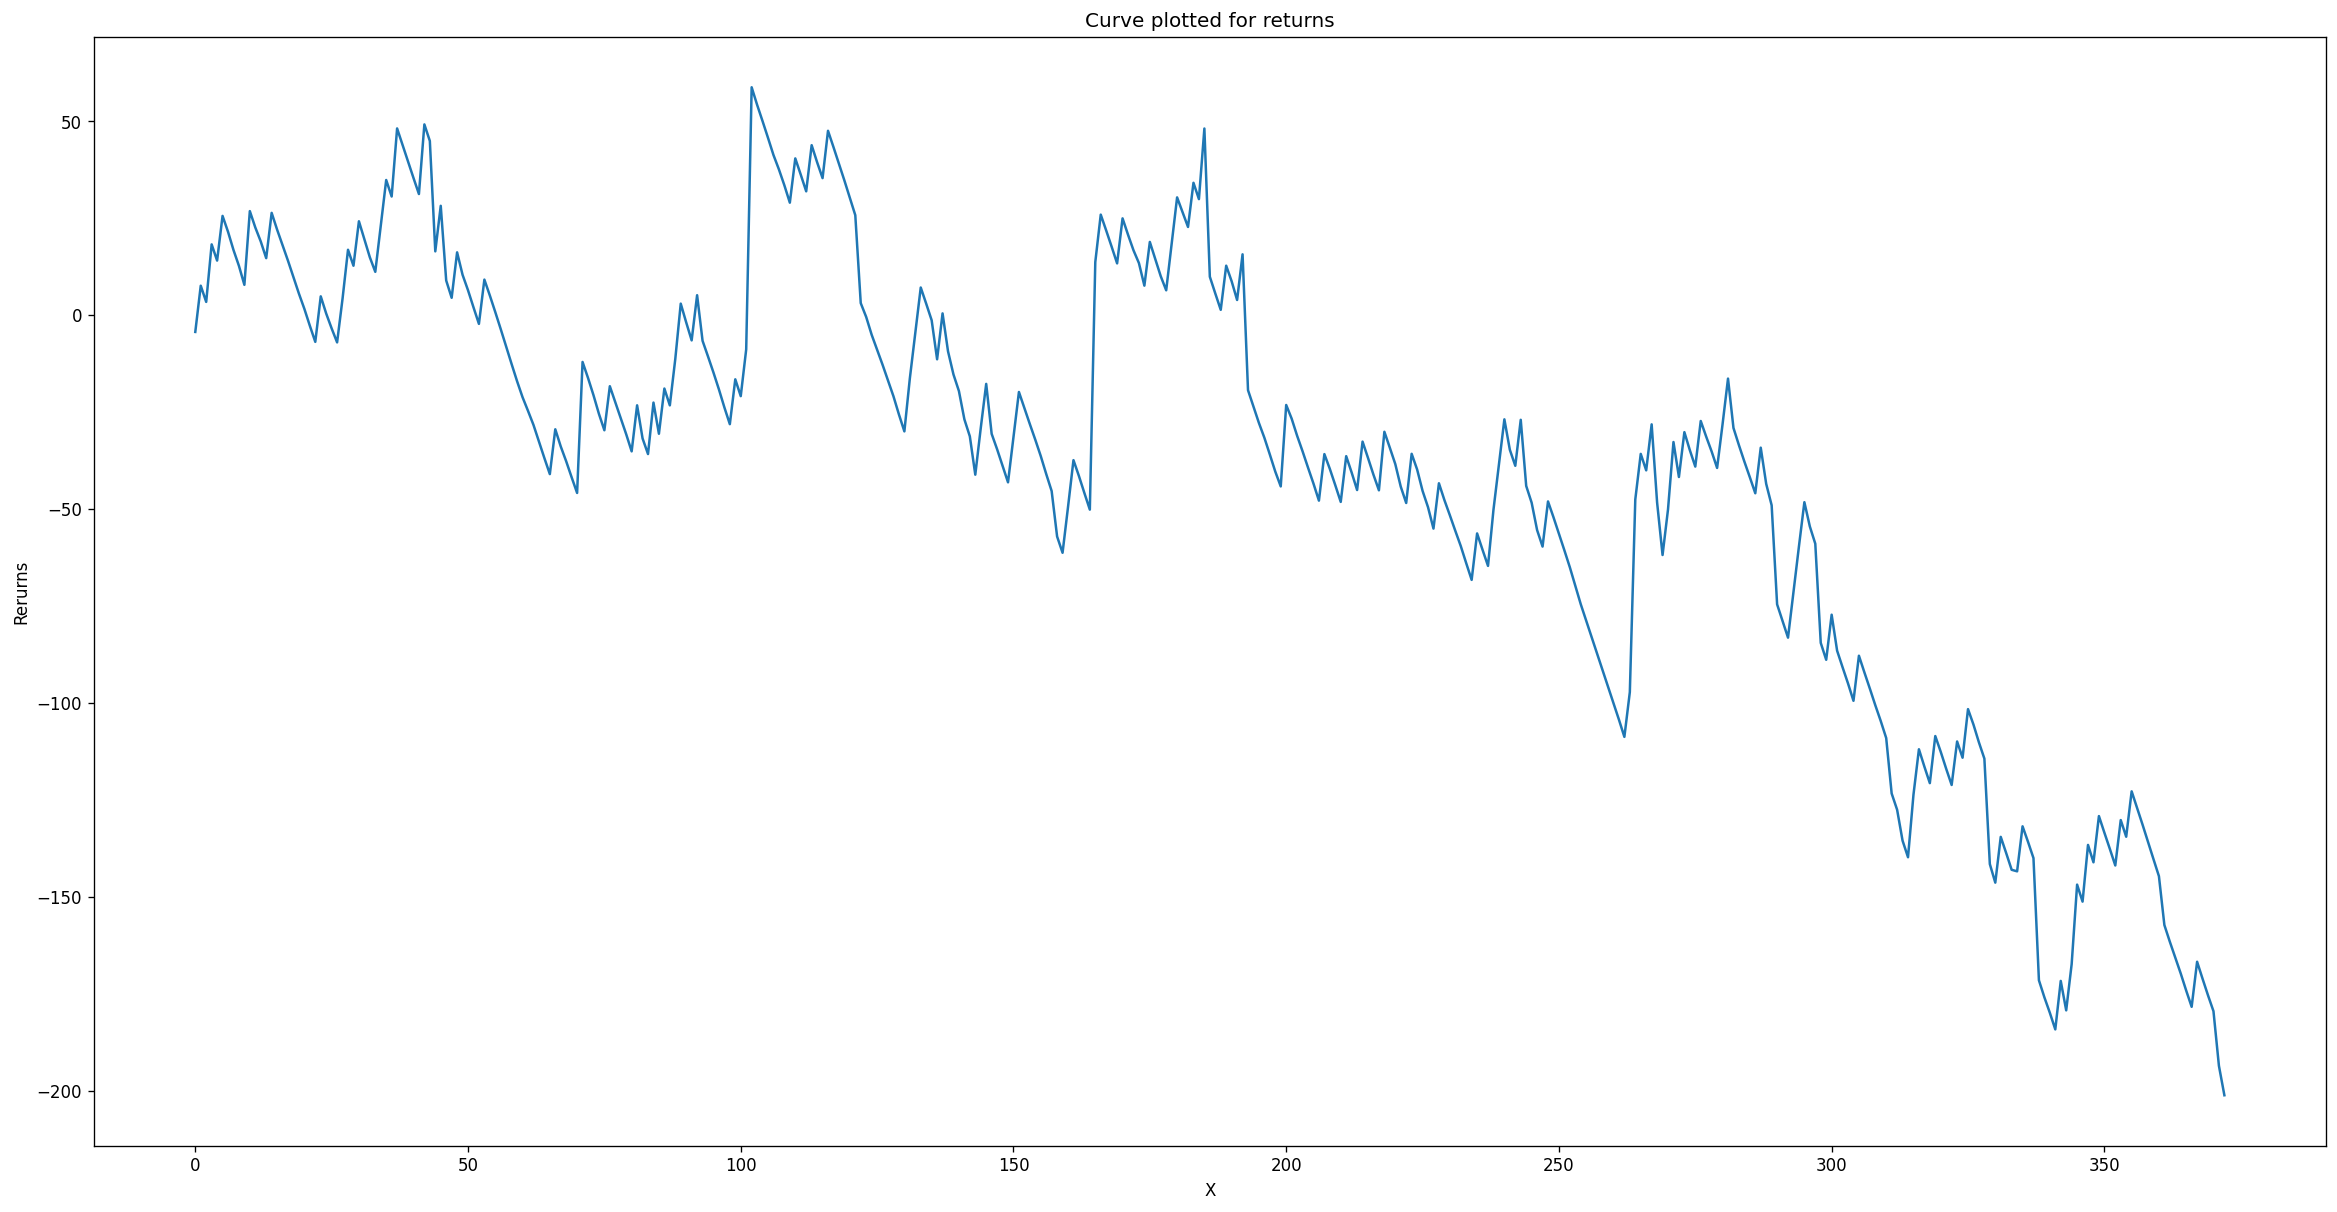

In [136]:
copy_trades = _trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

# Optimize

In [100]:
max_sl_params = [x / 10.0 for x in range(20, 45)]
risk_reward_ratio_params = [x / 10.0 for x in range(20, 40)]
optimize_stats, heatmap = bt.optimize(max_sl=max_sl_params,
                                      risk_reward_ratio=risk_reward_ratio_params,
                                        maximize='Return [%]',
                                        random_state=0,
                                        return_heatmap=True)

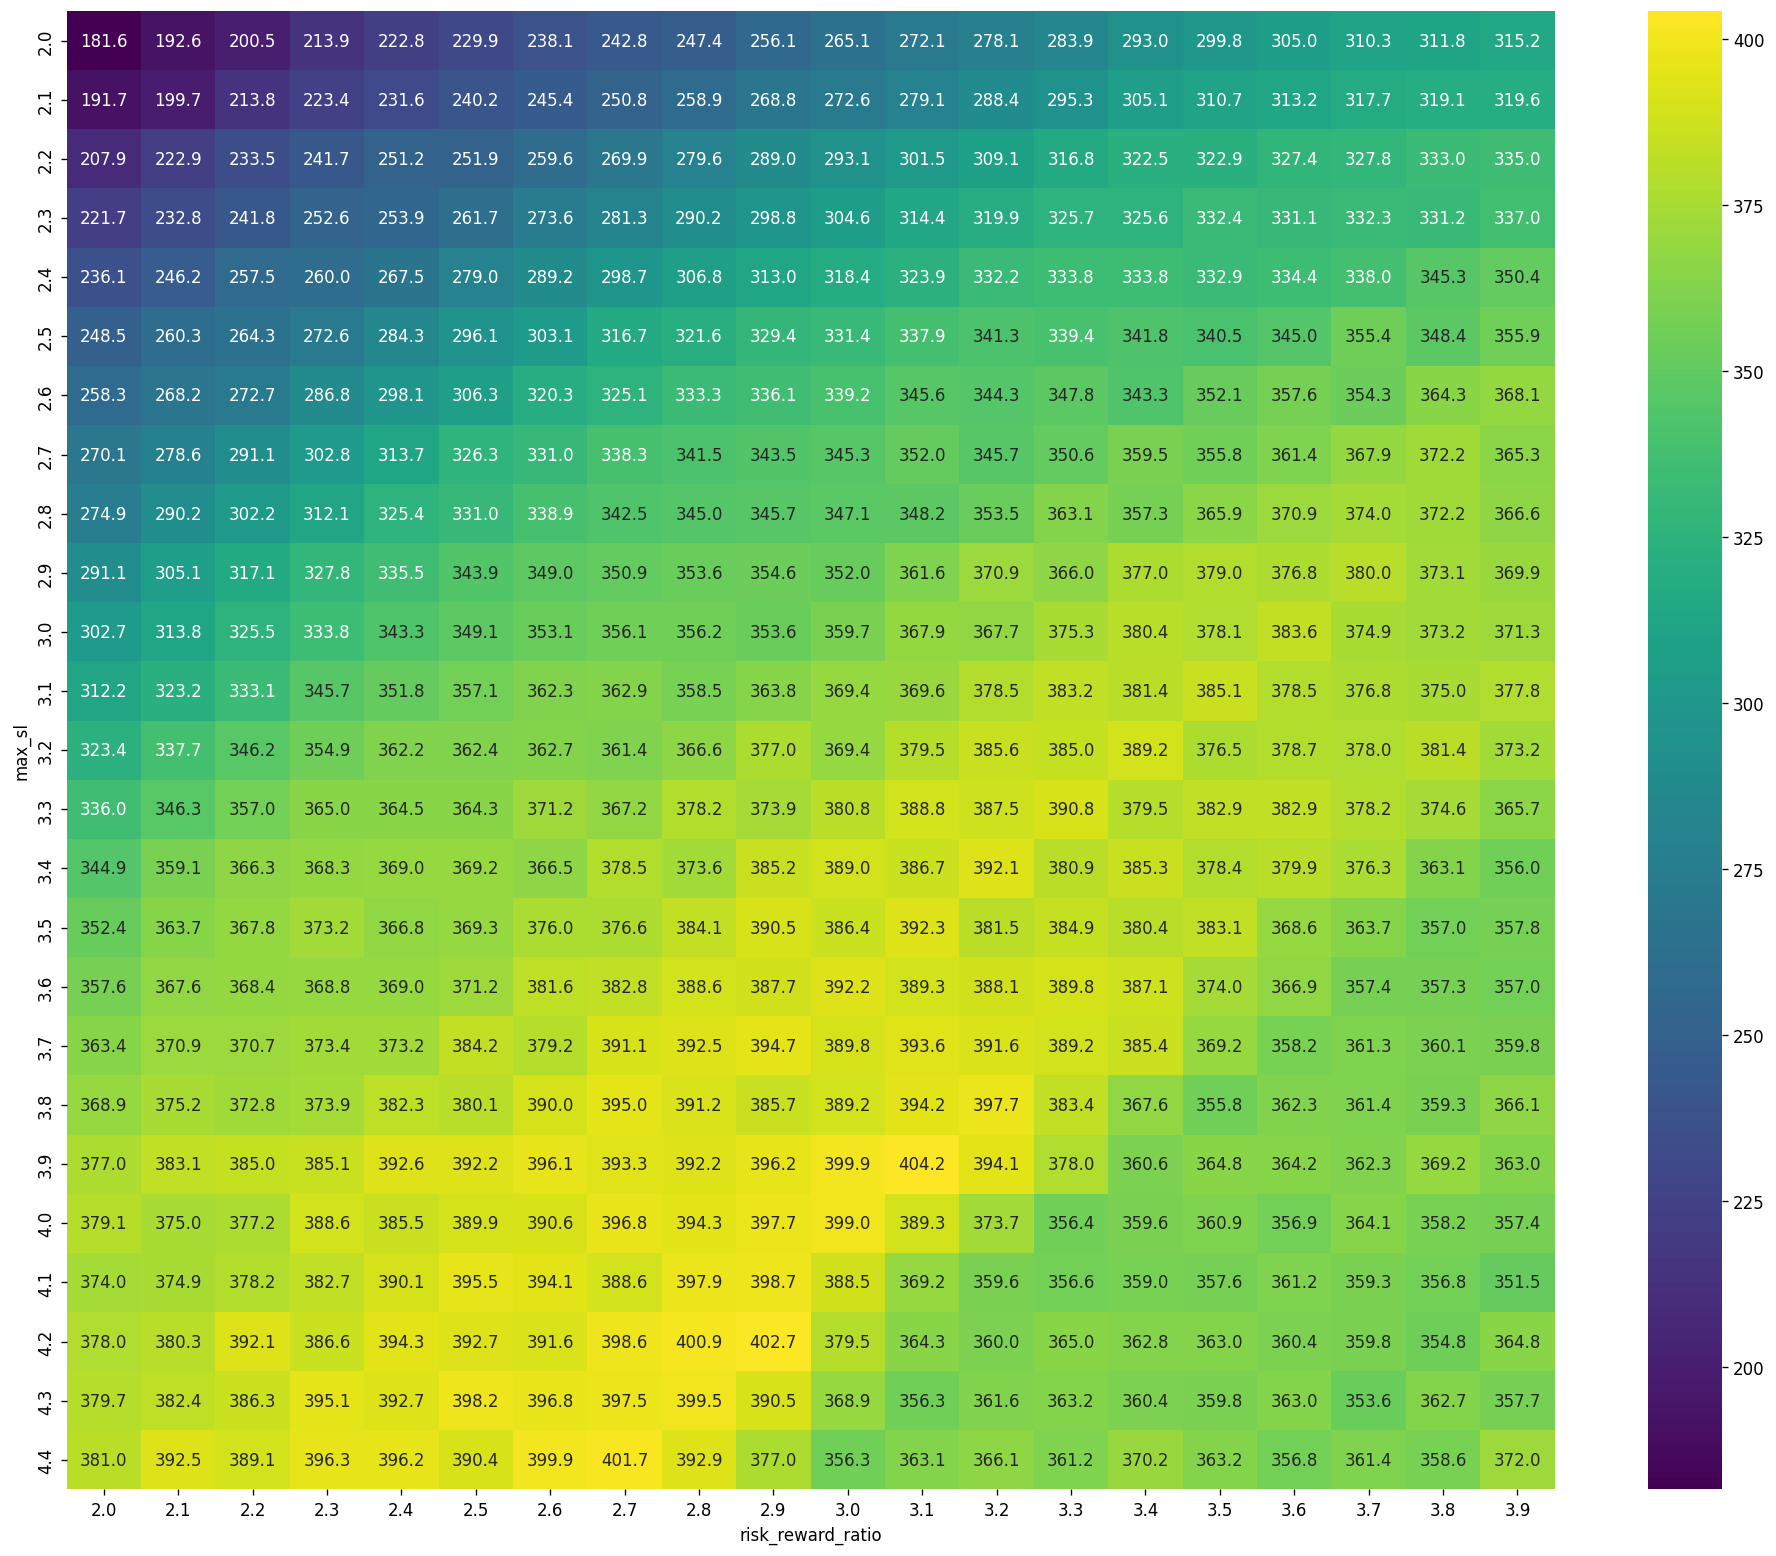

In [104]:
import seaborn as sns
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(20, 16))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.1f')
plt.show()

In [105]:
heatmap_df

risk_reward_ratio,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9
max_sl,,,,,,,,,,,,,,,,,,,,
2.0,181.571409,192.637579,200.521945,213.852871,222.825205,229.906785,238.075589,242.765604,247.410170,256.131936,265.130480,272.082414,278.050503,283.939164,293.014935,299.830411,305.024667,310.288175,311.785730,315.172937
2.1,191.696793,199.674493,213.810751,223.398419,231.564039,240.210176,245.409034,250.849302,258.851725,268.778577,272.601370,279.062821,288.428769,295.294860,305.099801,310.665514,313.165159,317.677585,319.123877,319.619623
2.2,207.904288,222.915213,233.541215,241.670137,251.195427,251.903899,259.624080,269.934859,279.602311,288.980632,293.083855,301.469707,309.126322,316.763559,322.517288,322.893446,327.415631,327.813013,332.976057,334.955039
2.3,221.680677,232.822679,241.820935,252.558891,253.868029,261.652211,273.624323,281.326444,290.217585,298.751722,304.638007,314.447418,319.931321,325.694260,325.631689,332.391674,331.061915,332.325317,331.244411,336.990701
2.4,236.133077,246.205311,257.478145,259.961515,267.541139,278.983631,289.156483,298.664957,306.785014,312.984665,318.362941,323.872472,332.242764,333.763359,333.791677,332.865265,334.354408,338.007759,345.341637,350.365732
2.5,248.538367,260.312783,264.345299,272.624256,284.263415,296.113083,303.084588,316.736377,321.624639,329.366585,331.392975,337.892831,341.258115,339.351633,341.787620,340.539799,344.998761,355.374108,348.429088,355.852441
2.6,258.289998,268.216264,272.658300,286.806818,298.094475,306.253979,320.313101,325.069365,333.336645,336.138369,339.193619,345.619567,344.336651,347.793675,343.302515,352.139060,357.614887,354.321878,364.255219,368.124543
2.7,270.095077,278.585525,291.132621,302.832412,313.725384,326.298443,331.021188,338.312014,341.509214,343.528746,345.314971,351.986842,345.707877,350.552035,359.540999,355.760118,361.367359,367.876926,372.232359,365.345515
2.8,274.899329,290.248649,302.163511,312.134498,325.398220,331.012803,338.940295,342.465490,345.032355,345.663437,347.085157,348.225115,353.518607,363.086039,357.294757,365.925643,370.870473,373.965174,372.242337,366.583351


In [106]:
heatmap_df.max()

risk_reward_ratio
2.0    381.042119
2.1    392.465072
2.2    392.075361
2.3    396.320511
2.4    396.232735
2.5    398.216257
2.6    399.917167
2.7    401.737452
2.8    400.886349
2.9    402.697831
3.0    399.907194
3.1    404.205840
3.2    397.708883
3.3    390.795145
3.4    389.156567
3.5    385.133365
3.6    383.551834
3.7    380.012795
3.8    381.448719
3.9    377.765165
dtype: float64